In [1]:
import json
import os
import numpy as np
import itertools

from transformers import PreTrainedTokenizerFast, AutoTokenizer, AutoConfig
from transformers import XLMRobertaTokenizerFast
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

/home/jirka/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [2]:
from notebook_utils import *

In [3]:
# disable FutureWarning from seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Load the results for XNLI (cross-lingual transfer)

In [4]:
result_dir = "../../../models"

languages = ('ar', 'zh', 'el', 'tr', 'es', 'en')

tokenizer_types = ('bpe-tokenization', 'merged-tokenization', 'multilingual-tokenization', 'nooverlap-tokenization')
vocab_sizes = (120000, 120000, 120000, 20000)

In [5]:
task = 'XNLI'
metric = 'accuracy'

xnli_results = []

post_training = 'PROBE'

for seed in range(2000, 2005):
    for lang_src in languages:
        for lang_tgt in languages:
            for tok_type, vocab_size in zip(tokenizer_types, vocab_sizes):
                result_file = f"{result_dir}/{task}_{post_training}/{tok_type}/alpha-0.25_alpha-train-0.25_N-{vocab_size}_{seed}/{lang_src}/{metric}_evaluation/{lang_tgt}/{metric}_all.txt"
                
                if not os.path.exists(result_file):
                    print("not found! skipping", result_file)
                    continue
                with open(result_file, 'r') as in_file:
                    res = json.load(in_file)[f'eval_{metric}']

                xnli_results.append(
                    {
                        'lang_src': lang_src,
                        'lang_tgt': lang_tgt,
                        'tokenizer_type': tok_type,
                        'post_training': post_training,
                        'seed': seed,
                        'vocab_size': vocab_size,
                        'accuracy': res
                    }
                )

In [6]:
ls ../../../models/XNLI_PROBE/bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2004/en/accuracy_evaluation/en/accuracy_all.txt

../../../models/XNLI_PROBE/bpe-tokenization/alpha-0.25_alpha-train-0.25_N-120000_2004/en/accuracy_evaluation/en/accuracy_all.txt*


In [7]:
df_all = pd.DataFrame(xnli_results)
df_all['lang_src'] = pd.Categorical(df_all['lang_src'], categories=df_all['lang_src'].unique())
df_all['lang_tgt'] = pd.Categorical(df_all['lang_tgt'], categories=df_all['lang_tgt'].unique())

In [8]:
def plot_boxplot(df, post_training, title, ax=None):
    df = df[df['post_training'] == post_training]
    ax = sns.boxplot(x='tokenizer_type', y='accuracy', data=df, showmeans=True, ax=ax)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=30)
    ax.set_title(title)

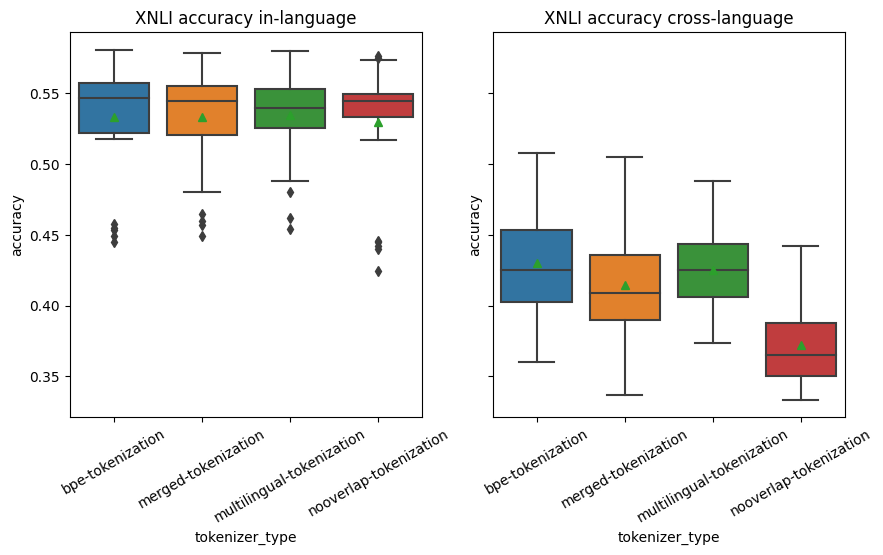

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# inlang
df = df_all[df_all['lang_src'] == df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"XNLI accuracy in-language", ax=ax[0])
# crosslang
df = df_all[df_all['lang_src'] != df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"XNLI accuracy cross-language", ax=ax[1])

In [10]:
def plot_barplots(df, post_training):
    df = df[df['post_training'] == post_training]
    # plot barplot FacetGrid for lang_src and lang_tgt with tokenizer_type as hue and accuracy as value
    g = sns.FacetGrid(df, col="lang_src", row="lang_tgt", hue="tokenizer_type", margin_titles=True)
    g.map(sns.barplot, "tokenizer_type", "accuracy", order=tokenizer_types)
    for ax in g.axes.flat:
        ax.set_xticklabels(ax.get_xticklabels(), rotation=30)

    # plt.title(f"XNLI {post_training} {metric} for the crosslingual transfers")
    # show legend
    g.add_legend()
    plt.show()

In [11]:
def plot_heatmaps(df, baseline, baseline_title, compared=[], compared_titles=[], figsize=None):
    # plot heatmap for lang_src and lang_tgt with accuracy as value for tokenizer_type == 'multilingual-tokenization'
    # make 3 plots horizontally
    figsize = figsize if figsize is not None else (30/4*(1+len(compared)), 5)
    fig, axs = plt.subplots(1, 1+len(compared), squeeze=False, figsize=figsize)
    df_baseline = df[baseline]
    # average over the seeds
    df_baseline = df_baseline.groupby(['lang_src', 'lang_tgt', 'tokenizer_type']).mean().reset_index()
    df_baseline = df_baseline.pivot("lang_src", "lang_tgt", "accuracy")
    sns.heatmap(df_baseline, annot=True, fmt=".2f", cmap="YlGnBu", ax=axs[0][0])
    axs[0][0].set_title(f"XNLI accuracy with {baseline_title}")
    # plt.show()
    # plot heatmaps for the rest of the tokenizer_types as a delta to 'multilingual-tokenization'
    for i, comp, compared_title in zip(range(1, len(compared)+1), compared, compared_titles):
        ax = axs[0][i]
        df_delta = df[comp]
        df_delta = df_delta.groupby(['lang_src', 'lang_tgt', 'tokenizer_type']).mean().reset_index()
        df_delta = df_delta.pivot("lang_src", "lang_tgt", "accuracy")
        df_delta = df_delta - df_baseline
        # choose a diverging colormap
        # set the scale to be between -1 and 1
        sns.heatmap(df_delta, annot=True, fmt=".2f", cmap="RdBu", vmin=-0.1, vmax=0.1, ax=ax)
        ax.set_title(f"{compared_title} - {baseline_title}")
    plt.show()

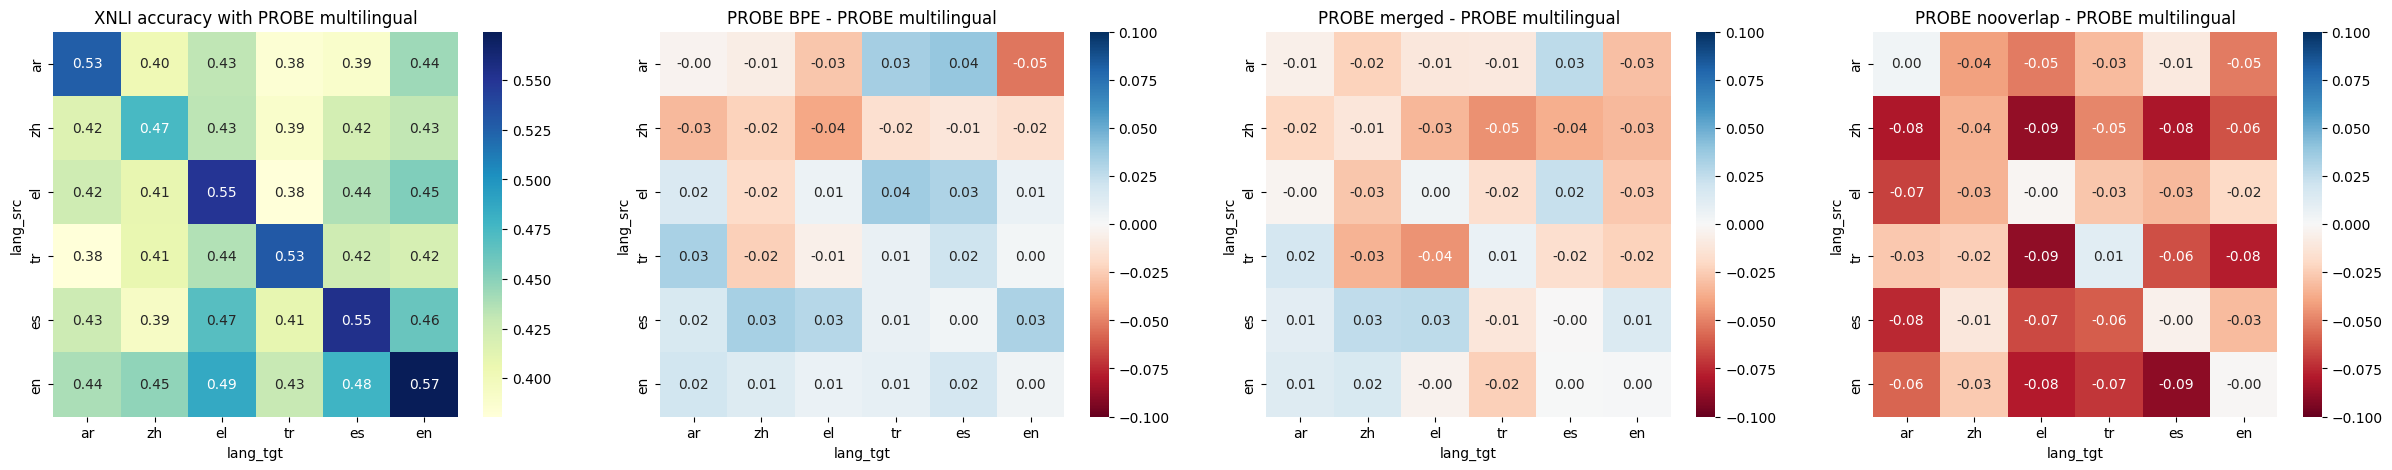

In [12]:
post_training = 'PROBE'
df = df_all
plot_heatmaps(df, df['tokenizer_type'] == 'multilingual-tokenization', f'{post_training} multilingual', 
    compared=[df['tokenizer_type'] == 'bpe-tokenization', df['tokenizer_type'] == 'merged-tokenization', df['tokenizer_type'] == 'nooverlap-tokenization'], 
    compared_titles=[f'{post_training} BPE', f'{post_training} merged', f'{post_training} nooverlap']
    )

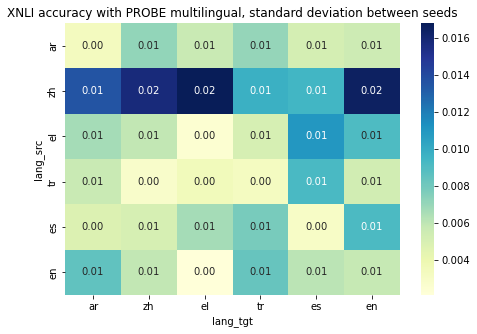

In [42]:
post_training = 'PROBE'
df = df_all
# run with hardcoded std function
plot_heatmaps(df, df['tokenizer_type'] == 'multilingual-tokenization', f'{post_training} multilingual, standard deviation between seeds')

In [13]:
result_dir = "../../../models"

languages = ("ar", "bg", "de", "el", "en", "es", "fr", "hi", "ru", "sw", "th", "tr", "ur", "vi", "zh")

tokenizer_types = ('20l-bpe-tokenization', '20l-merged-tokenization', '20l-multilingual-tokenization')
vocab_sizes = (120000, 120000, 120000)

In [14]:
task = 'XNLI'
metric = 'accuracy'

xnli_results = []

post_training = 'PROBE'

for seed in [2000]:
    for lang_src in languages:
        for lang_tgt in languages:
            for tok_type, vocab_size in zip(tokenizer_types, vocab_sizes):
                result_file = f"{result_dir}/{task}_{post_training}/{tok_type}/alpha-0.25_alpha-train-0.25_N-{vocab_size}_{seed}/{lang_src}/{metric}_evaluation/{lang_tgt}/{metric}_all.txt"
                
                if not os.path.exists(result_file):
                    print("not found! skipping", result_file)
                    continue
                with open(result_file, 'r') as in_file:
                    res = json.load(in_file)[f'eval_{metric}']

                xnli_results.append(
                    {
                        'lang_src': lang_src,
                        'lang_tgt': lang_tgt,
                        'tokenizer_type': tok_type,
                        'post_training': post_training,
                        'seed': seed,
                        'vocab_size': vocab_size,
                        'accuracy': res
                    }
                )

In [15]:
df_all = pd.DataFrame(xnli_results)
df_all['lang_src'] = pd.Categorical(df_all['lang_src'], categories=df_all['lang_src'].unique())
df_all['lang_tgt'] = pd.Categorical(df_all['lang_tgt'], categories=df_all['lang_tgt'].unique())

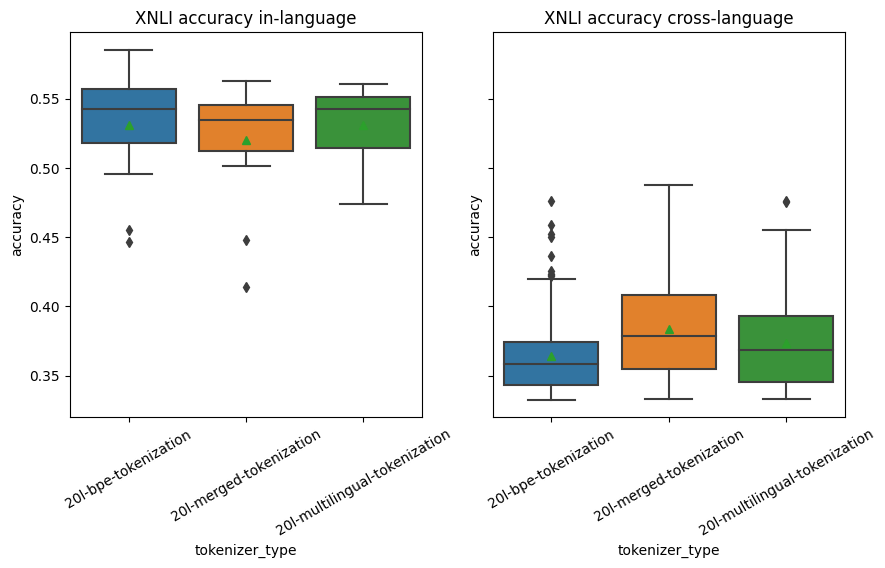

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
# inlang
df = df_all[df_all['lang_src'] == df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"XNLI accuracy in-language", ax=ax[0])
# crosslang
df = df_all[df_all['lang_src'] != df_all['lang_tgt']]
plot_boxplot(df, 'PROBE', f"XNLI accuracy cross-language", ax=ax[1])

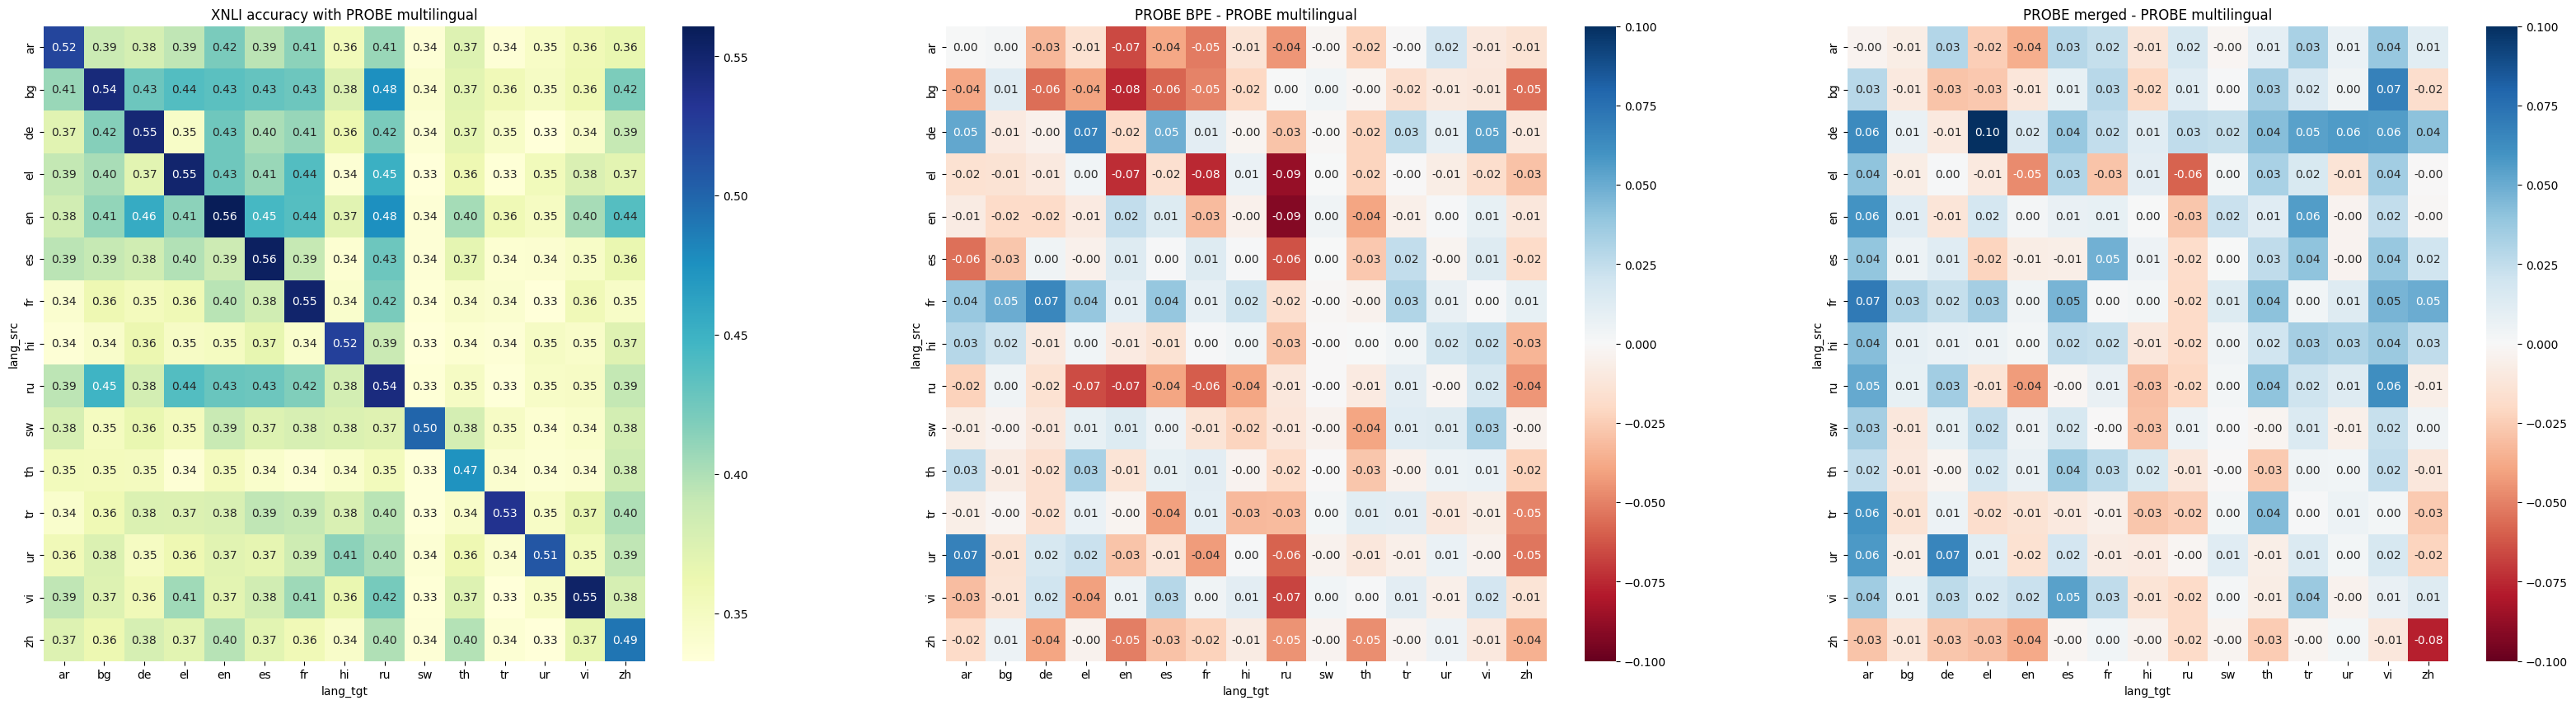

In [17]:
post_training = 'PROBE'
df = df_all
plot_heatmaps(df, df['tokenizer_type'] == '20l-multilingual-tokenization', f'{post_training} multilingual', 
    compared=[df['tokenizer_type'] == '20l-bpe-tokenization', df['tokenizer_type'] == '20l-merged-tokenization'], 
    compared_titles=[f'{post_training} BPE', f'{post_training} merged'],
    figsize=(40, 10)
    )

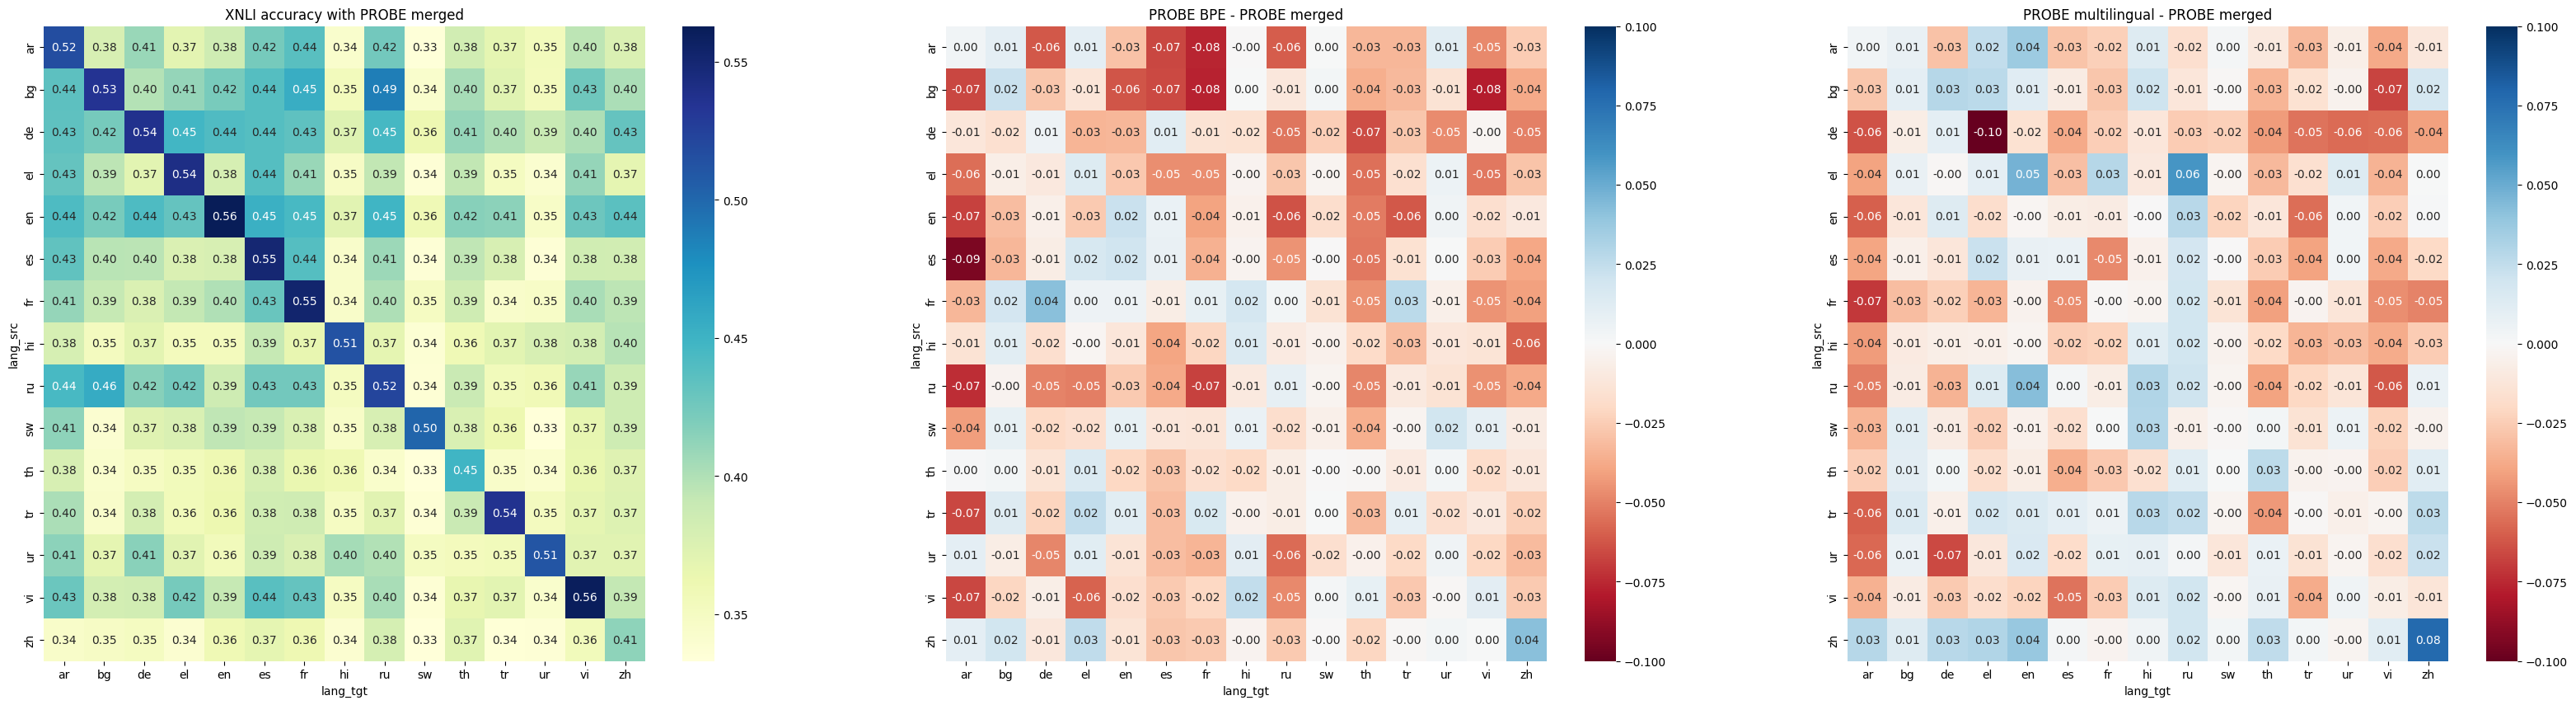

In [18]:
post_training = 'PROBE'
df = df_all
plot_heatmaps(df, df['tokenizer_type'] == '20l-merged-tokenization', f'{post_training} merged', 
    compared=[df['tokenizer_type'] == '20l-bpe-tokenization', df['tokenizer_type'] == '20l-multilingual-tokenization'], 
    compared_titles=[f'{post_training} BPE', f'{post_training} multilingual'],
    figsize=(40, 10)
    )

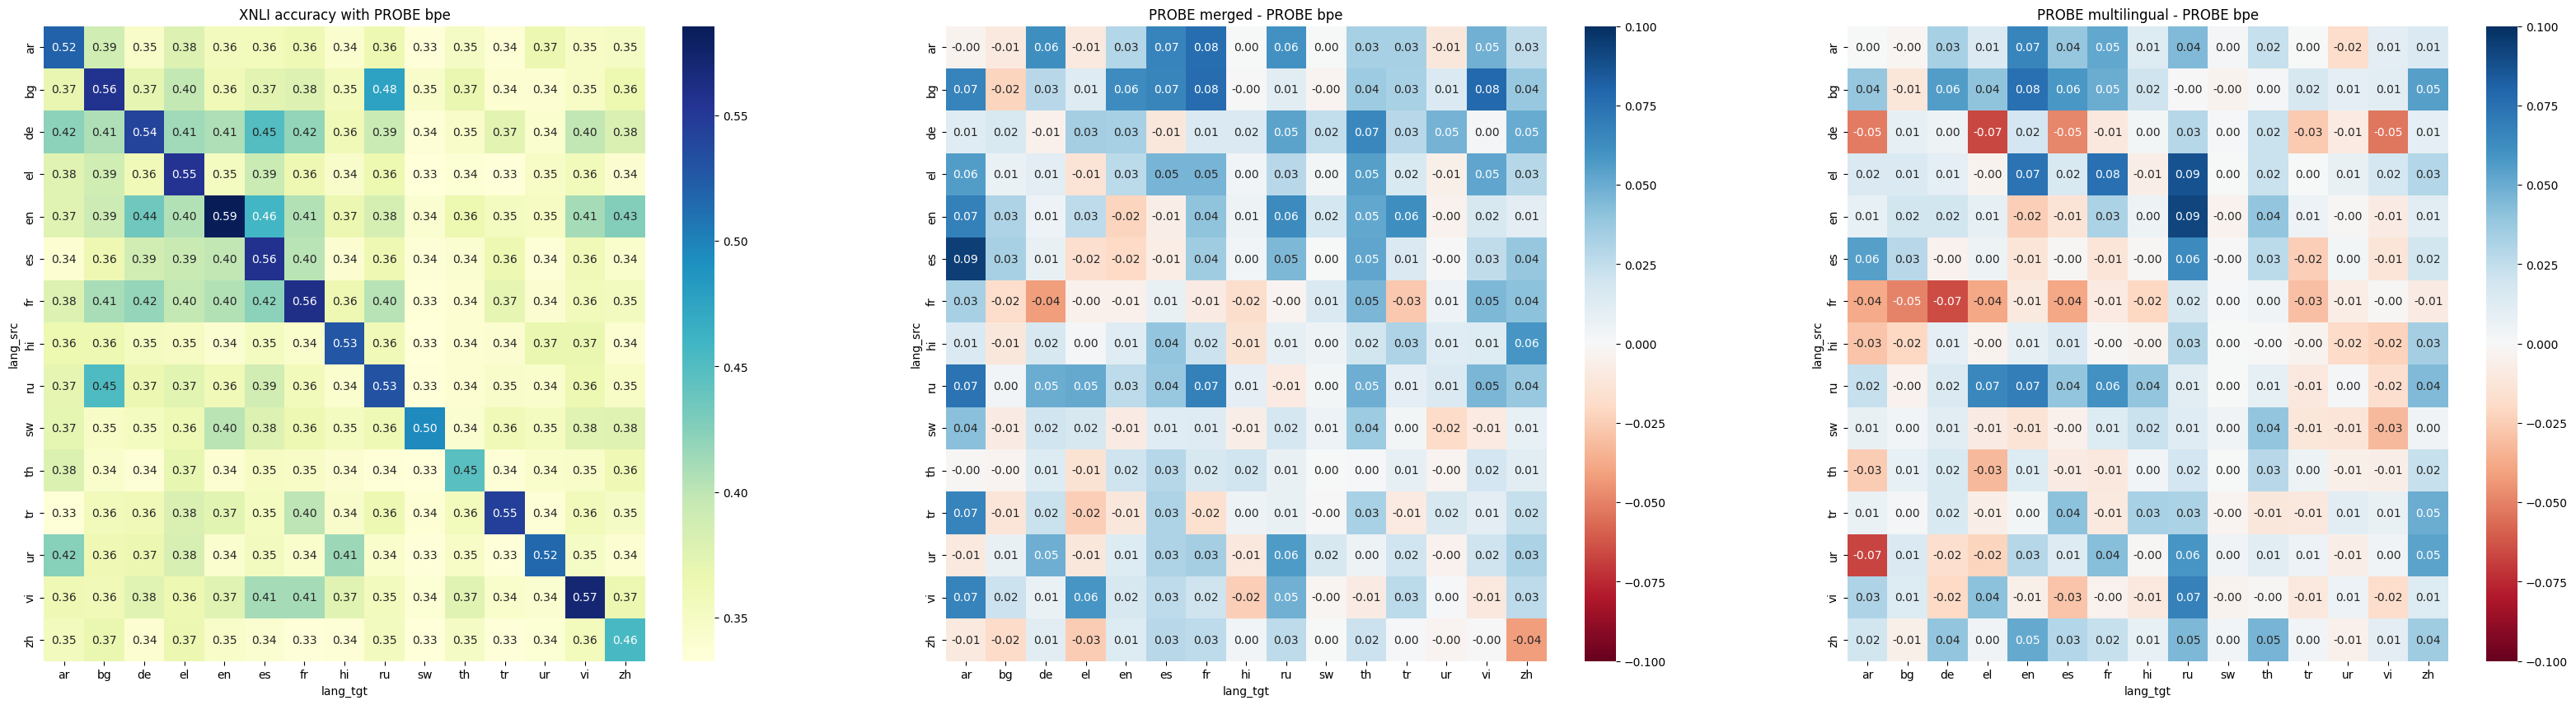

In [19]:
post_training = 'PROBE'
df = df_all
plot_heatmaps(df, df['tokenizer_type'] == '20l-bpe-tokenization', f'{post_training} bpe', 
    compared=[df['tokenizer_type'] == '20l-merged-tokenization', df['tokenizer_type'] == '20l-multilingual-tokenization'], 
    compared_titles=[f'{post_training} merged', f'{post_training} multilingual'],
    figsize=(40, 10)
    )

# Old results:

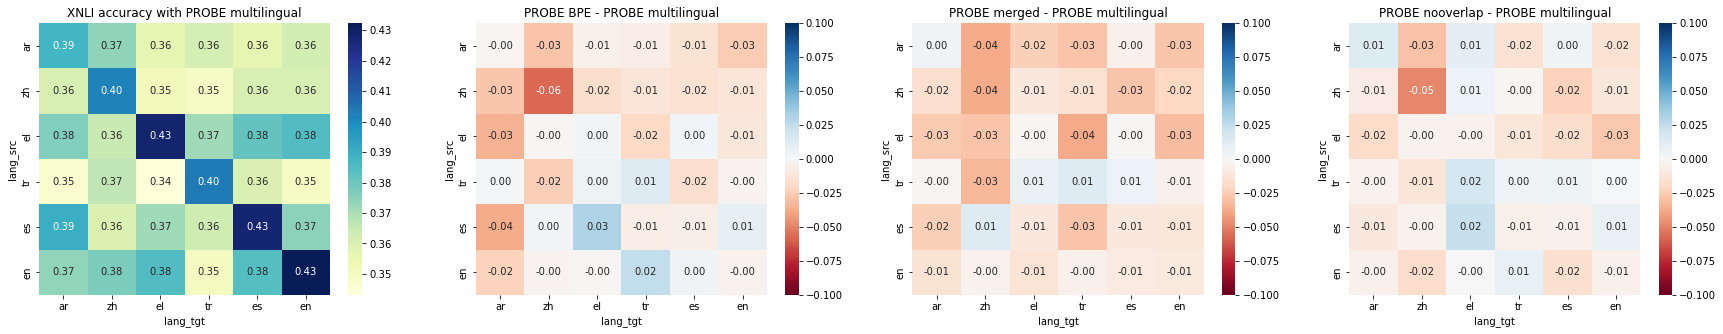

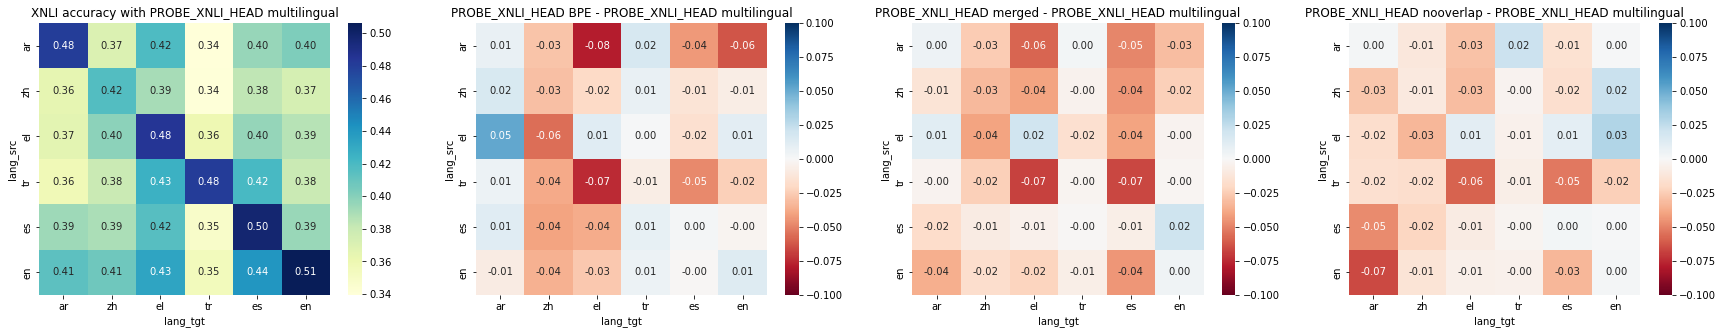

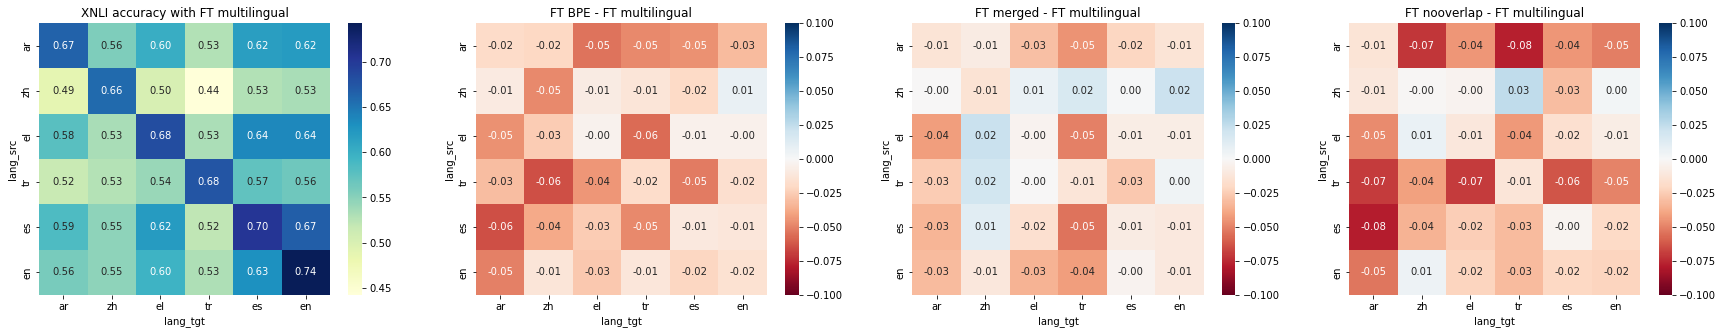

In [71]:
for post_training in ('PROBE', 'PROBE_XNLI_HEAD', 'FT', 'FT_XNLI_HEAD'):
    df = df_all[df_all['post_training'] == post_training]
    plot_heatmaps(df, df['tokenizer_type'] == 'multilingual-tokenization', f'{post_training} multilingual', 
        compared=[df['tokenizer_type'] == 'bpe-tokenization', df['tokenizer_type'] == 'merged-tokenization', df['tokenizer_type'] == 'nooverlap-tokenization'], 
        compared_titles=[f'{post_training} BPE', f'{post_training} merged', f'{post_training} nooverlap']
        )